# Anomaly Detection





이상치 탐지(Annomaly Detection) 는 원래 통계학의 과업 중 하나 입니다.

정상 범주를 넘어선 관측값에 대한 판정이 이상치 탐지에 해당하는데, 통계적 품질관리등의 분야에서 활용됩니다.

## 사용한 이상탐지 방법

AutoEncoder를 학습시킨다.

다수의 정상 이미지(1 이미지)와 소수의 비정상 이미지(3 이미지)를 100:1의 비율로 사용.

학습된 이후에 정상 이미지(1 이미지)는 잘 복원된다. 하지만 소수 포함된 비정상 이미지(3 이미지)는 복원이 잘 안된다.

입력과 출력의 차이를 구해서 복원이 잘 안된 것을 비정상으로 판단하여 검출한다.

다수에 속한 소수의 데이터를 비정상으로 간주하고 이를 찾아내는 방법





## 영상 처리와 Anomaly Detection



이번 예제의 목적은 이상한 것을 찾아내는 것입니다.

이미 알고 있는 데이터와는 크게 다른 모습을 보이는 것을 찾는 것이죠. 이에 대한 전통적인 방법은 분산치를 이용하는 방법인데, 딥러닝에서도 크게 다르지 않습니다. MSE를 통해서 찾는 방법을 사용합니다.

이번 예제에서 사용할 방법은 AutoEncoder입니다. AutoEncoder는 대표적인 비지도학습의 한 방법입니다.

신경망의 노드를 갈수록 줄여 자료를 압축한 뒤, 그 압축된 자료를 풀어 원본을 작업하는 과정을 거치는 것으로 학습하게 됩니다.

실제 학습에서는 2개의 라벨을 통해 학습을 진행합니다. 1에 해당하는 값을 정상치, 3에 해당하는 값을 이상치로 둡니다. 이상치 탐지도 결국에는 이진 분류문제이므로 이런 방식으로 처리한 것 같군요.

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
# from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# import argparse
import random
import pickle
import cv2
import matplotlib
# matplotlib.use("Agg")

일단 필요한 패키지들은 위와 같습니다.

## 모델 설정

일반적인 Autoencoder는 Affine(Dense) 만을 사용한 일반적인 계층이지만, 여기서는 ConvNet을 사용하여 특질 추출 과정을 사용합니다.


인코더 :

ConvNet을 통과해 특질 추출을 마친 신호는 Dense를 거쳐 잠재의미 신호로 변환 되는데, 이 잠재의미 신호는 반드시 이전 입력값보다 노드의 수가 적어야 합니다.

디코더 :

여타 다른 AutoEncoder와 마찬가지로 적은 차원의 잠재의미 신호를 점차 불려나가 원본을 복원하는 형태로 진행합니다.

이 때, 원본이 ConvNet을 통과하였기 때문에 Conv Transpose를 사용하여 역으로 입력값을 증가시키는 방법을 사용합니다.(저도 잘 몰라서 수학적 설명은 생략합니다.)

오토 인코더 :

이렇게 만든 인코더와 디코더를 이어 붙으면 그것이 곧 오토인코더 입니다. 실제 구현체에서는 케라스 함수형 API를 사용해 인코더의 입력과 디코더의 출력을 연결했습니다.



In [2]:
# import the necessary packages

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

## 데이터 셋 빌드

데이터셋으로는 간단한 mnist data를 사용합니다. 아래 함수는 데이터 셋을 랜덤하게 섞고 찾고자 하는 라벨만 가져오는 함수입니다.

※ np.where 는 조건에 맞는 idx 값을 찾아줍니다.

※ random.shuffle, np.shuffle 모두 반환값이 없습니다.

※ np.vstack 은 행을 추가해줍니다. np.concat(axis=0) 으로도 같은 효과를 봅니다.


In [3]:
def build_unsupervised_dataset(data, labels, validLabel=1,
	anomalyLabel=3, contam=0.01, seed=42):
	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	validIdxs = np.where(labels == validLabel)[0]
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

	# randomly shuffle both sets of indexes
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

	# compute the total number of anomaly data points to select
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	print("len(validIdx)=",len(validIdxs))
	print("len(anomalyIdxs)=",len(anomalyIdxs))
 
	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

	# stack the valid images and anomaly images together to form a
	# single data matrix and then shuffle the rows
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	# return the set of images
	return images

## 예측 시각화

예측 결과를 원본과 묶어서 시각적으로 표현할 수 있게 만들어주는 함수 입니다.

흑백 사진을 기준으로 하므로, 픽셀 하나하나에 0~255 까지의 명도 값이 들어가게 됩니다.

※ np.hstack 은 열을 추가해줍니다. np.concat(axis=1) 으로도 같은 효과를 봅니다.

In [4]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

## 매개변수 입력

항상 그렇듯 매개변수를 입력해 줄 수가 없으니 해당 아규먼트들을 분석해 일일이 적어줄 필요가 있습니다.

In [5]:
# import argparse
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", type=str, required=True,
# 	help="path to output dataset file")
# ap.add_argument("-m", "--model", type=str, required=True,
# 	help="path to output trained autoencoder")
# ap.add_argument("-v", "--vis", type=str, default="recon_vis.png",
# 	help="path to output reconstruction visualization file")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output plot file")
# args = vars(ap.parse_args())


# 경로를 제 구글 드라이브에 주기위한 코드입니다.
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/Colab\ Notebooks/AnomalyDetection




In [6]:
# 다행히 모든 아규먼트가 경로를 지정할 뿐입니다.
# 솔직히 귀찮아서 같은 폴더에 몰아두기로 합니다.
dataset_path = "dataset"
model_path = "model"
vis_path = "vis.png"
plot_path = "plot.png"

## 데이터 전처리

데이터는 mnist인데, 따로 준비할 필요는 없고 다운로드 받으면 됩니다.

그 후 아주 약간의 전처리를 가해줍니다.

위에서 만들었던 함수를 호출해서 데이터 셋을 처리해주고, 

입력에 알맞게 차원을 하나 늘려준뒤 (channel 차원을 맞춰줍니다.),

값의 범위를 0~1로 조정합니다.

그리고 적당히 나눠줍니다.

<br>


1 이미지가 정상이고, 3 이미지가 비정상입니다.


In [7]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

# build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1) # axis = 0 에 추가되는 것 같습니다.
images = images.astype("float32") / 255.0

# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

[INFO] loading MNIST dataset...
[INFO] creating unsupervised dataset...
len(validIdx)= 6742
len(anomalyIdxs)= 67


In [8]:
print(trainX.shape)
print(testX.shape)

(5447, 28, 28, 1)
(1362, 28, 28, 1)


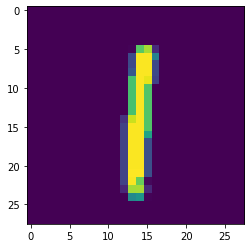

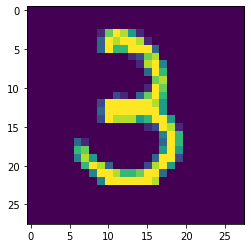

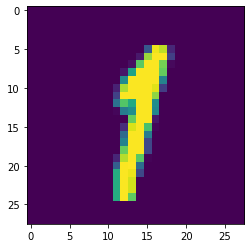

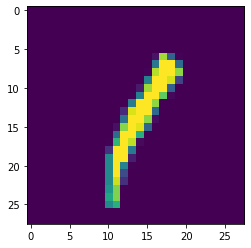

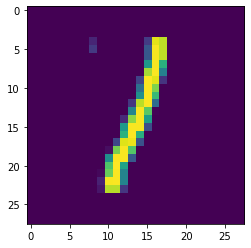

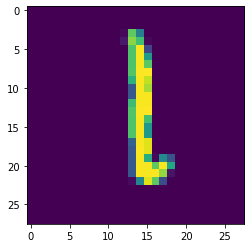

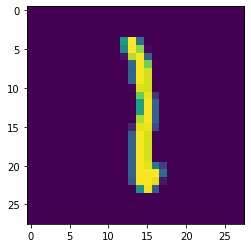

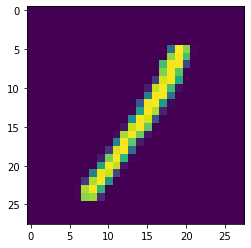

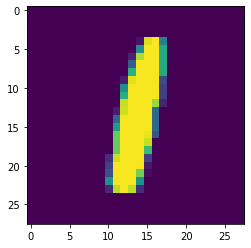

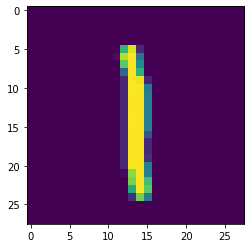

In [10]:
for i in range(10):
  plt.imshow(trainX[i].reshape((28,28)))
  plt.show()

## 파라미터 설정 및 학습

Optimizer 로는 Adam을 사용합니다.

loss는 처음에 밝혔는 mse를 사용합니다.

아래 코드에서는 autoencoder만 사용했지만, encoder의 경우, 학습을 막고 전이학습을 위한 용도로 사용할 수 있습니다.

In [11]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
encoder.summary()
decoder.summary()
autoencoder.summary()

[INFO] building autoencoder...
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch

In [12]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/20
171/171 [==============================] - 2s 12ms/step - loss: 0.0476 - val_loss: 0.0404
Epoch 2/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0135 - val_loss: 0.0205
Epoch 3/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0043 - val_loss: 0.0090
Epoch 4/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 10/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0022 - val_loss: 0.002

[INFO] making predictions...
[INFO] saving image data...
[INFO] saving autoencoder...


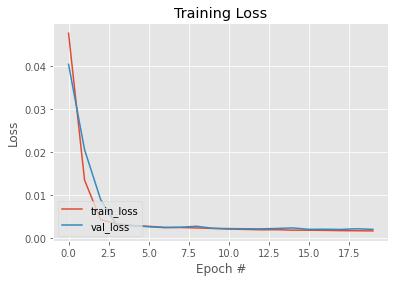

In [13]:

# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(vis_path, vis)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)

# serialize the image data to disk
print("[INFO] saving image data...")
f = open(dataset_path, "wb")
f.write(pickle.dumps(images))
f.close()

# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(model_path, save_format="h5")

In [17]:
# USAGE
# python find_anomalies.py --dataset output/images.pickle --model output/autoencoder.model

# import the necessary packages
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import pickle
import cv2


In [14]:
!wget https://github.com/dhrim/pis_study/raw/master/anomaly_detection/images.pickle

--2020-08-14 09:59:29--  https://github.com/dhrim/pis_study/raw/master/anomaly_detection/images.pickle
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/pis_study/master/anomaly_detection/images.pickle [following]
--2020-08-14 09:59:29--  https://raw.githubusercontent.com/dhrim/pis_study/master/anomaly_detection/images.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21353190 (20M) [application/octet-stream]
Saving to: ‘images.pickle’

images.pickle       100%[===================>]  20.36M  35.7MB/s    in 0.6s    

2020-08-14 09:59:30 (35.7 MB/s) - ‘images.pickle’ saved [21353190/21353190]


In [15]:

# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", type=str, required=True,
# 	help="path to input image dataset file")
# ap.add_argument("-m", "--model", type=str, required=True,
# 	help="path to trained autoencoder")
# ap.add_argument("-q", "--quantile", type=float, default=0.999,
# 	help="q-th quantile used to identify outliers")
# args = vars(ap.parse_args())

args = { 'dataset':'images.pickle', 'model':model_path, 'quantile':0.999 } 

[INFO] loading autoencoder and image data...


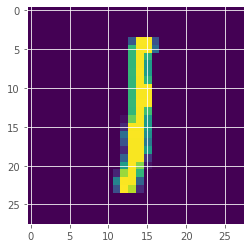

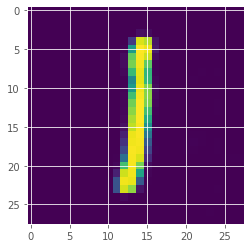

In [24]:
# load the model and image data from disk
print("[INFO] loading autoencoder and image data...")
autoencoder = load_model(args["model"])
images = pickle.loads(open(args["dataset"], "rb").read())

plt.imshow(images.squeeze()[0])
plt.show()

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(images)
plt.imshow(decoded.squeeze()[0])
plt.show()

## 차이 검출

입력과 출력의 차이를 비교하여 그 값을 errors에 답는다.

In [25]:
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(images, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

## 임계치 이상 추출
차이가 임계치 이상인 것만 추린다.

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, args["quantile"])
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.043802100002765666
[INFO] 7 outliers found


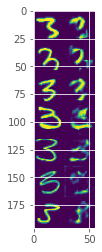

In [21]:


# initialize the outputs array
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (images[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
plt.imshow(outputs.squeeze())
